In [0]:
!kill -9 -1

#  perform authorization

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Prepare datas

In [0]:
import pandas as pd
import numpy as np

import re
import os
import csv

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [0]:
path = "drive/capstone/"

In [0]:
codes = [i[0:4] for i in os.listdir(path+"Announcement_clean")]

In [6]:
codes[3]

'0017'

In [0]:
def data_process(code):
    
    announcement = pd.read_csv(path+"Announcement_clean/{}HK.csv".format(code), index_col=1)
    announcement = announcement.loc[:, ~announcement.columns.str.contains('^Unnamed')]
    announcement.index = pd.to_datetime(announcement.index, format="%Y-%m-%d", errors='ignore')
    
    stock = pd.read_csv(path+"stock_price/{}.HK.csv".format(code))
    stock = stock[(stock["Close"].astype("object") != "null")]
    stock["rise_in_next_day"] = stock["Close"].astype("float").shift(-1)/stock["Close"].astype("float") >=1
    stock["Date"] = pd.to_datetime(stock.Date, format="%Y-%m-%d", errors='ignore')
    stock = stock.set_index("Date")
    
    stock_moving_5 = stock.rolling(window=5).mean()
    
    df = pd.merge(announcement, stock[["rise_in_next_day", "Volume"]], left_index=True, right_index=True)
    df2 = pd.merge(df, stock_moving_5["Volume"].to_frame(), left_index=True, right_index=True)
    df2.rename(columns = {"Volume_x":'Volume', "Volume_y":'moving_average_volume_5'}, inplace=True)
    
    return df2.dropna()

In [0]:
#df = pd.DataFrame()
#for i in codes:
#    df = df.append(data_process(i))
df = data_process(codes[6])

In [9]:
df.head()

,text,rise_in_next_day,Volume,moving_average_volume_5
Date,,,,
2002-09-24,this circular important requires your immediat...,False,961015.0,789305.4
2003-01-02,the stock exchange hong limited takes no respo...,True,1210830.0,3199551.8
2003-02-28,holdings limited incorporated hong under compa...,False,3748958.0,1695536.8
2003-03-27,the stock exchange hong limited takes no respo...,True,1211642.0,1230204.2
2003-04-23,this circular important requires your immediat...,False,2812029.0,1319267.8


In [10]:
df.shape

(708, 4)

In [0]:
df = df.dropna()

In [12]:
df.rise_in_next_day.value_counts()

True     402
False    306
Name: rise_in_next_day, dtype: int64

In [0]:
train = df[df.index < '2015-01-01']
test = df[df.index > '2014-12-31']

In [14]:
train.shape

(524, 4)

In [15]:
test.shape

(184, 4)

# Basic model

In [16]:
trainheadlines = train["text"].values

basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(trainheadlines)
print(basictrain.shape)

(524, 6771)


In [0]:
basicmodel = LogisticRegression()
basicmodel = basicmodel.fit(basictrain, train["rise_in_next_day"])

In [0]:
testheadlines = test["text"].values

basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest)

In [19]:
pd.crosstab(test["rise_in_next_day"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,False,True
Actual,,
False,25,64
True,28,67


In [20]:
acc=accuracy_score(test['rise_in_next_day'], predictions)
acc

0.5

In [21]:
basicwords = basicvectorizer.get_feature_names()
basiccoeffs = basicmodel.coef_.tolist()[0]
coeffdf = pd.DataFrame({'Word' : basicwords, 
                        'Coefficient' : basiccoeffs})
coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffdf.head(10)

,Coefficient,Word
6595,1.548755,wan
2462,0.609113,final
6125,0.605112,three
3468,0.515762,letter
3849,0.493987,morning
6691,0.487502,wing
2051,0.486238,employees
3414,0.484335,law
1821,0.463016,disposal
1041,0.452032,co


In [22]:
coeffdf.tail(10)

,Coefficient,Word
5092,-0.424420,repurchases
5900,-0.435388,sunny
836,-0.445547,capital
5221,-0.485404,revised
5091,-0.485747,repurchased
612,-0.509012,behalf
6665,-0.534616,which
511,-0.653480,august
4105,-0.727496,ordinary
2491,-0.731950,five


# Advanced model

In [0]:
trainheadlines = train["text"].values

advancedvectorizer = CountVectorizer(ngram_range=(2,2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

In [24]:
print(advancedtrain.shape)

(524, 107213)


In [0]:
advancedmodel = LogisticRegression()
advancedmodel = advancedmodel.fit(advancedtrain, train["rise_in_next_day"])

In [0]:
testheadlines = test["text"]

advancedtest = advancedvectorizer.transform(testheadlines)
advpredictions = advancedmodel.predict(advancedtest)

In [27]:
pd.crosstab(test["rise_in_next_day"], advpredictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,False,True
Actual,,
False,20,69
True,20,75


In [28]:
acc=accuracy_score(test['rise_in_next_day'], advpredictions)
acc

0.5163043478260869

In [29]:
advwords = advancedvectorizer.get_feature_names()
advcoeffs = advancedmodel.coef_.tolist()[0]
advcoeffdf = pd.DataFrame({'Words' : advwords, 
                        'Coefficient' : advcoeffs})
advcoeffdf = advcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
advcoeffdf.head(10)

,Coefficient,Words
29366,0.748247,east wan
102608,0.744948,wan hong
96420,0.658329,three independent
52536,0.657174,lee three
79748,0.535295,repurchased shares
87516,0.458228,shares opening
34021,0.448813,exercised new
51153,0.406870,junior wing
58894,0.406385,mm scrip
27335,0.403651,discount discount


In [30]:
advcoeffdf.tail(10)

,Coefficient,Words
91786,-0.485545,submitted tat
106999,-0.496301,yet shares
36717,-0.502543,five independent
59171,-0.544820,month were
79727,-0.579941,repurchased closing
50114,-0.595729,issued march
59144,-0.699664,month ordinary
86774,-0.762233,share repurchases
29300,-0.767109,east hong
79766,-1.204425,repurchases share


# deep

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils

from keras.models import Sequential, Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten, BatchNormalization, MaxPooling1D
from keras.layers.core import Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU

from keras.layers.convolutional import Conv1D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras import backend as K

Using TensorFlow backend.


In [0]:
train = df[df.index < '2014-01-01']
test = df[df.index > '2013-12-31']

In [0]:
y_train = train["rise_in_next_day"].values
y_test = test["rise_in_next_day"].values

In [0]:
trainheadlines = [str(i) for i in train["text"].values]
testheadlines = [str(i) for i in test["text"].values]

# LSTM

In [0]:
max_features = 400000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
maxlen = 15000
batch_size = 32
nb_classes = 2

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(trainheadlines)
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [37]:
word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 6413 unique tokens


In [38]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen, padding='pre', truncating='pre')
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen, padding='pre', truncating='pre')

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (466, 15000)
X_test shape: (242, 15000)


In [39]:
# TODO: GLOVE embedding (pre-trained)
print('Loading Glove Model...')
gloveFile = path+'glove.6B/glove.6B.300d.txt'
words = pd.read_table(gloveFile, sep=" ", header=None, quoting=csv.QUOTE_NONE)
print(words.head(5))
print('shape of glove model',words.shape)

Loading Glove Model...
   0         1         2         3         4         5         6         7    \
0  the  0.046560  0.213180 -0.007436 -0.458540 -0.035639  0.236430 -0.288360   
1    , -0.255390 -0.257230  0.131690 -0.042688  0.218170 -0.022702 -0.178540   
2    . -0.125590  0.013630  0.103060 -0.101230  0.098128  0.136270 -0.107210   
3   of -0.076947 -0.021211  0.212710 -0.722320 -0.139880 -0.122340 -0.175210   
4   to -0.257560 -0.057132 -0.671900 -0.380820 -0.364210 -0.082155 -0.010955   

        8         9      ...          291       292       293       294  \
0  0.215210 -0.134860    ...    -0.013064 -0.296860 -0.079913  0.195000   
1  0.107560  0.058936    ...     0.075968 -0.014359 -0.073794  0.221760   
2  0.236970  0.328700    ...     0.060148 -0.156190 -0.119490  0.234450   
3  0.121370 -0.070866    ...    -0.366730 -0.386030  0.302900  0.015747   
4 -0.082047  0.460560    ...    -0.012806 -0.597070  0.317340 -0.252670   

        295       296       297       298    

In [40]:
wordkeys=words.iloc[:,0]
print('wordkeys type of file', type(wordkeys))
words2 = words.rename(columns={ words.columns[0]: "words" })
words2['words'].apply(str)

wordkeys type of file <class 'pandas.core.series.Series'>


0                   the
1                     ,
2                     .
3                    of
4                    to
5                   and
6                    in
7                     a
8                     "
9                    's
10                  for
11                    -
12                 that
13                   on
14                   is
15                  was
16                 said
17                 with
18                   he
19                   as
20                   it
21                   by
22                   at
23                    (
24                    )
25                 from
26                  his
27                   ''
28                   ``
29                   an
              ...      
399970          fardell
399971             nurc
399972           sauzal
399973           gousmi
399974       numbskulls
399975       visalakshi
399976          lieserl
399977       ulundurpet
399978           arpita
399979            ineta
399980          

In [41]:
embeddings_index = words2.set_index('words').T.to_dict('list')
print('Found {} word vectors.'.format(len(embeddings_index)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


Found 399998 word vectors.


In [42]:
print('Building Embedding Matrix...')
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

Building Embedding Matrix...


In [43]:
print('Build model...')

main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')
#x = Embedding(output_dim=EMBEDDING_DIM, input_dim=max_features, input_length=maxlen)(main_input)
x = embedding_layer(main_input)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

conv_out = Flatten()(x)

auxiliary_input = Input(shape=(2,), name='aux_input')


x = concatenate([conv_out, auxiliary_input])

x = BatchNormalization()(Dense(64, activation='relu')(x))
x = BatchNormalization()(Dense(64, activation='relu')(x))
x = BatchNormalization()(Dense(64, activation='relu')(x))

main_output = Dense(2, activation='softmax', name='main_output')(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=main_output)

print('Done')

Build model...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Done


In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 15000)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15000, 300)   1924200     main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 14996, 128)   192128      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 2999, 128)    0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [0]:
X1 = X_train
X2 = train[["Volume","moving_average_volume_5"]].astype("float").values

In [0]:
X1_test = X_test
X2_test = test[["Volume","moving_average_volume_5"]].astype("float").values

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

print('Train...')
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
#reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, verbose=1)
history = model.fit([X1,X2], Y_train, batch_size=batch_size, epochs=50,
          validation_data=([X1_test,X2_test], Y_test))
score, acc = model.evaluate([X1_test,X2_test], Y_test,
                            batch_size=batch_size)


Train...
Train on 466 samples, validate on 242 samples
Epoch 1/50
466/466 [==============================] - 10s 21ms/step - loss: 0.8374 - acc: 0.5322 - val_loss: 0.7295 - val_acc: 0.5744
Epoch 2/50
466/466 [==============================] - 6s 14ms/step - loss: 0.7497 - acc: 0.5515 - val_loss: 0.7231 - val_acc: 0.5661
Epoch 3/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6876 - acc: 0.5901 - val_loss: 0.7276 - val_acc: 0.6074
Epoch 4/50
466/466 [==============================] - 7s 14ms/step - loss: 0.7077 - acc: 0.5644 - val_loss: 0.6792 - val_acc: 0.5744
Epoch 5/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6757 - acc: 0.5515 - val_loss: 0.7436 - val_acc: 0.5702
Epoch 6/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6829 - acc: 0.5644 - val_loss: 0.8725 - val_acc: 0.5661
Epoch 7/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6946 - acc: 0.5579 - val_loss: 0.8257 - val_acc: 0.5702
Epoch 8/50
46

466/466 [==============================] - 7s 14ms/step - loss: 0.6693 - acc: 0.6009 - val_loss: 0.7591 - val_acc: 0.4669
Epoch 11/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6753 - acc: 0.6073 - val_loss: 0.7498 - val_acc: 0.5537
Epoch 12/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6566 - acc: 0.6116 - val_loss: 0.7517 - val_acc: 0.5826
Epoch 13/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6319 - acc: 0.6288 - val_loss: 0.8004 - val_acc: 0.4669
Epoch 14/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6424 - acc: 0.6288 - val_loss: 0.8543 - val_acc: 0.5041
Epoch 15/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6571 - acc: 0.6159 - val_loss: 0.8381 - val_acc: 0.5620
Epoch 16/50
466/466 [==============================] - 7s 14ms/step - loss: 0.6172 - acc: 0.6674 - val_loss: 0.8113 - val_acc: 0.5331
Epoch 17/50
466/466 [==============================] - 7s 14ms/step - loss

466/466 [==============================] - 7s 14ms/step - loss: 0.6104 - acc: 0.6567 - val_loss: 0.8508 - val_acc: 0.5372
Epoch 20/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5847 - acc: 0.7082 - val_loss: 0.8621 - val_acc: 0.5289
Epoch 21/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5845 - acc: 0.6524 - val_loss: 0.8583 - val_acc: 0.5455
Epoch 22/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5716 - acc: 0.6974 - val_loss: 0.8545 - val_acc: 0.5207
Epoch 23/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5690 - acc: 0.7082 - val_loss: 0.8692 - val_acc: 0.4917
Epoch 24/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5626 - acc: 0.6974 - val_loss: 0.8443 - val_acc: 0.5083
Epoch 25/50
466/466 [==============================] - 6s 14ms/step - loss: 0.5725 - acc: 0.6824 - val_loss: 0.7955 - val_acc: 0.5000
Epoch 26/50
466/466 [==============================] - 7s 14ms/step - loss

466/466 [==============================] - 7s 14ms/step - loss: 0.5865 - acc: 0.6738 - val_loss: 0.8035 - val_acc: 0.5372
Epoch 29/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5504 - acc: 0.7103 - val_loss: 0.8113 - val_acc: 0.5455
Epoch 30/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5569 - acc: 0.6824 - val_loss: 0.8268 - val_acc: 0.5372
Epoch 31/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5494 - acc: 0.6760 - val_loss: 0.8305 - val_acc: 0.5289
Epoch 32/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5378 - acc: 0.7082 - val_loss: 0.8586 - val_acc: 0.5289
Epoch 33/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5231 - acc: 0.7103 - val_loss: 0.8922 - val_acc: 0.5496
Epoch 34/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5605 - acc: 0.6738 - val_loss: 0.8743 - val_acc: 0.5744
Epoch 35/50
466/466 [==============================] - 6s 14ms/step - loss

466/466 [==============================] - 7s 14ms/step - loss: 0.5083 - acc: 0.7425 - val_loss: 0.8904 - val_acc: 0.5331
Epoch 38/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5341 - acc: 0.6931 - val_loss: 0.9439 - val_acc: 0.5083
Epoch 39/50
466/466 [==============================] - 6s 14ms/step - loss: 0.5211 - acc: 0.7210 - val_loss: 0.8856 - val_acc: 0.5289
Epoch 40/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5043 - acc: 0.7210 - val_loss: 0.9001 - val_acc: 0.5702
Epoch 41/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5011 - acc: 0.7339 - val_loss: 0.8947 - val_acc: 0.5537
Epoch 42/50
466/466 [==============================] - 7s 14ms/step - loss: 0.5213 - acc: 0.7189 - val_loss: 0.9039 - val_acc: 0.5496
Epoch 43/50
466/466 [==============================] - 7s 14ms/step - loss: 0.4919 - acc: 0.7468 - val_loss: 1.0755 - val_acc: 0.4339
Epoch 44/50
466/466 [==============================] - 7s 14ms/step - loss

466/466 [==============================] - 6s 14ms/step - loss: 0.4666 - acc: 0.7511 - val_loss: 0.9507 - val_acc: 0.4793
Epoch 47/50
466/466 [==============================] - 7s 14ms/step - loss: 0.4869 - acc: 0.7382 - val_loss: 1.0577 - val_acc: 0.4793
Epoch 48/50
466/466 [==============================] - 7s 14ms/step - loss: 0.4829 - acc: 0.7275 - val_loss: 0.9813 - val_acc: 0.5124
Epoch 49/50
466/466 [==============================] - 7s 14ms/step - loss: 0.4987 - acc: 0.7425 - val_loss: 1.1306 - val_acc: 0.4669
Epoch 50/50
242/242 [==============================] - 1s 5ms/step


In [48]:
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds_lstm = model.predict([X1_test,X2_test], verbose=0)

Test score: 1.010885498247856
Test accuracy: 0.5206611580099941
Generating test predictions...


In [49]:
preds_lstm

array([[1.46610916e-01, 8.53389084e-01],
       [1.22890852e-01, 8.77109170e-01],
       [8.91152859e-01, 1.08847104e-01],
       [7.33624160e-01, 2.66375780e-01],
       [5.33796370e-01, 4.66203630e-01],
       [5.15910625e-01, 4.84089315e-01],
       [2.28871912e-01, 7.71128058e-01],
       [7.85379887e-01, 2.14620113e-01],
       [6.10443711e-01, 3.89556259e-01],
       [5.68181872e-01, 4.31818098e-01],
       [7.48326659e-01, 2.51673341e-01],
       [6.55919671e-01, 3.44080329e-01],
       [6.99812829e-01, 3.00187200e-01],
       [6.12190902e-01, 3.87809157e-01],
       [1.77643031e-01, 8.22356999e-01],
       [2.00335905e-01, 7.99664080e-01],
       [8.01586285e-02, 9.19841349e-01],
       [2.76400685e-01, 7.23599315e-01],
       [4.30546589e-02, 9.56945360e-01],
       [1.23922504e-01, 8.76077533e-01],
       [1.47113159e-01, 8.52886856e-01],
       [1.72543034e-01, 8.27456951e-01],
       [1.22556284e-01, 8.77443731e-01],
       [5.38060427e-01, 4.61939573e-01],
       [5.709770

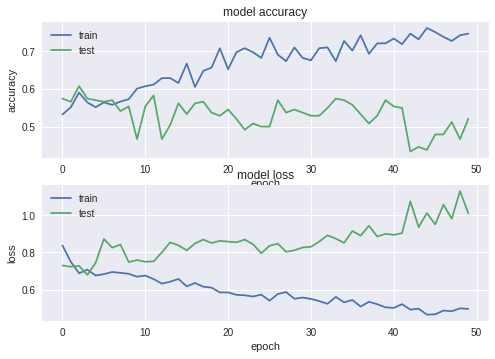

In [50]:
import matplotlib.pyplot as plt  
plt.figure(1)  

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

# Reference:
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/